In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

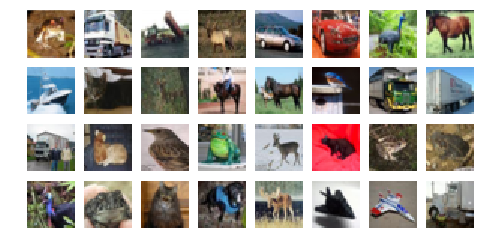

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

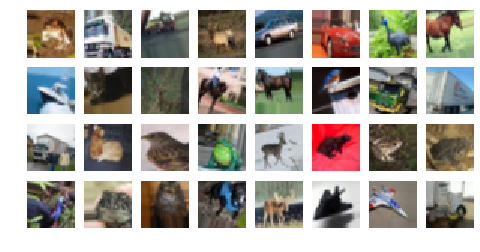

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

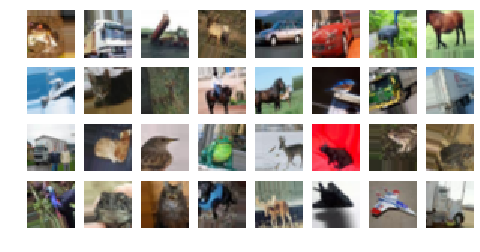

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
from tensorflow import keras
batch_size = 32
num_classes = 10
epochs = 5

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=[32,32,3]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
#model.summary()

In [10]:
model.save_weights("tmp.h5")

# Training without data augmentation

In [11]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [12]:
def cifar_generator(total_size, batch_size=32):
    while True:
        for indexs in range(0, total_size, batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = y_train[indexs: indexs+batch_size]
            yield images, labels
            
cifar_gen = cifar_generator(len(x_train), batch_size)

In [13]:
model.load_weights("tmp.h5")
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(0.01, 0.9),
              metrics=['accuracy'])

history = model.fit_generator(cifar_gen,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1562/1562 [==============================] - 404s 259ms/step - loss: 1.7458 - acc: 0.3567 - val_loss: 1.3377 - val_acc: 0.5181
Epoch 2/5
1562/1562 [==============================] - 380s 243ms/step - loss: 1.2521 - acc: 0.5508 - val_loss: 1.0194 - val_acc: 0.6327
Epoch 3/5
1562/1562 [==============================] - 392s 251ms/step - loss: 1.0174 - acc: 0.6399 - val_loss: 0.9497 - val_acc: 0.6633
Epoch 4/5
1562/1562 [==============================] - 422s 270ms/step - loss: 0.8762 - acc: 0.6921 - val_loss: 0.8459 - val_acc: 0.7084
Epoch 5/5
1562/1562 [==============================] - 397s 254ms/step - loss: 0.7766 - acc: 0.7285 - val_loss: 0.7599 - val_acc: 0.7405
Test loss: 0.7598522691726685
Test accuracy: 0.7405


# Training with data augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_test = x_test.astype('float32')
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [16]:
def cifar_aug_generator(total_size, batch_size=32):
    while True:
        for indexs in range(0, total_size, batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = y_train[indexs: indexs+batch_size]
            images = next(data_generator.flow(images, shuffle=False))
            images = images.astype('float32')
            images /= 255
            yield images, labels
             
cifar_gen = cifar_aug_generator(len(x_train), batch_size)

In [17]:
model.load_weights("tmp.h5")
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(0.01, 0.9),
              metrics=['accuracy'])

history = model.fit_generator(cifar_gen,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1562/1562 [==============================] - 437s 280ms/step - loss: 1.9499 - acc: 0.2735 - val_loss: 1.5552 - val_acc: 0.4245
Epoch 2/5
1562/1562 [==============================] - 434s 278ms/step - loss: 1.6103 - acc: 0.4076 - val_loss: 1.3677 - val_acc: 0.5030
Epoch 3/5
1562/1562 [==============================] - 421s 270ms/step - loss: 1.4473 - acc: 0.4781 - val_loss: 1.2148 - val_acc: 0.5614
Epoch 4/5
1562/1562 [==============================] - 421s 269ms/step - loss: 1.3350 - acc: 0.5176 - val_loss: 1.1648 - val_acc: 0.5856
Epoch 5/5
1562/1562 [==============================] - 401s 257ms/step - loss: 1.2517 - acc: 0.5511 - val_loss: 1.0626 - val_acc: 0.6201
Test loss: 1.0625911752700805
Test accuracy: 0.6201
